In [1]:
import os
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report, confusion_matrix

from tqdm import tqdm
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

In [2]:
train_data = 'Desktop/Training'
test_data = 'Desktop/Testing'
categories = ['glioma','meningioma','notumor','pituitary']

In [3]:
folds = [os.path.join(train_data, catg) for catg in categories]
folds

['Desktop/Training\\glioma',
 'Desktop/Training\\meningioma',
 'Desktop/Training\\notumor',
 'Desktop/Training\\pituitary']

In [4]:
folds2 = [os.path.join(test_data, catg) for catg in categories]
folds2

['Desktop/Testing\\glioma',
 'Desktop/Testing\\meningioma',
 'Desktop/Testing\\notumor',
 'Desktop/Testing\\pituitary']

In [5]:
for fold in folds:
    print(fold.split('/')[1], ':' ,len(os.listdir(fold)))

Training\glioma : 1321
Training\meningioma : 1339
Training\notumor : 1595
Training\pituitary : 1457


In [6]:
for fold2 in folds2:
    print(fold2.split('/')[1], ':' ,len(os.listdir(fold2)))

Testing\glioma : 300
Testing\meningioma : 306
Testing\notumor : 405
Testing\pituitary : 300


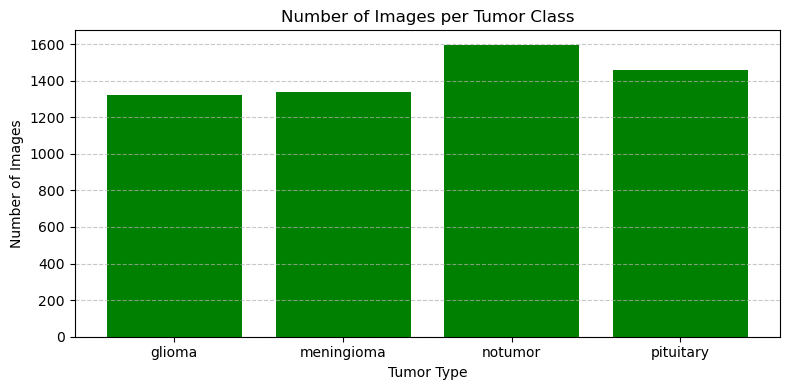

In [7]:
labels = ['glioma', 'meningioma', 'notumor', 'pituitary']
values = [1321, 1339, 1595, 1457]
plt.figure(figsize=(8, 4))
plt.bar(labels, values, color='green')
plt.title('Number of Images per Tumor Class')
plt.xlabel('Tumor Type')
plt.ylabel('Number of Images')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

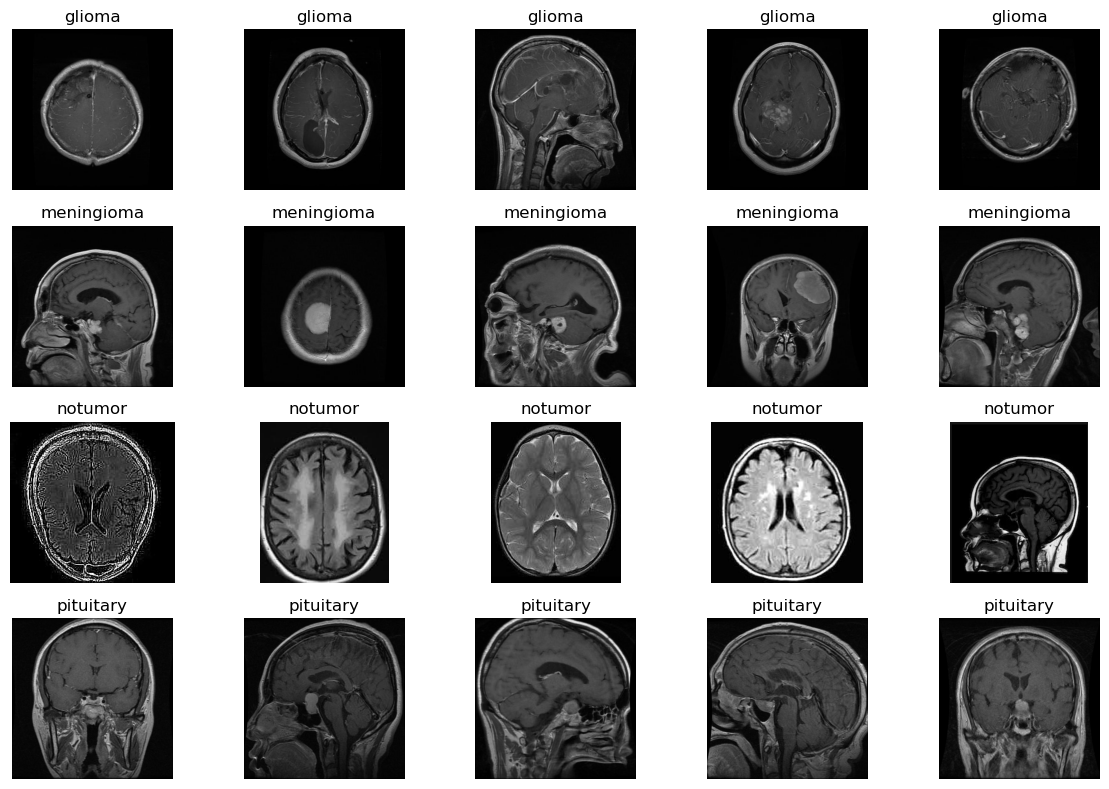

In [8]:
# Number of samples per category to display
samples_per_class = 5

plt.figure(figsize=(12, 8))

# Loop through categories
for idx, category in enumerate(categories):
    folder_path = os.path.join(train_data, category)
    images = os.listdir(folder_path)

    # Pick random images from this category
    sample_imgs = random.sample(images, min(samples_per_class, len(images)))
    for i, img_name in enumerate(sample_imgs):
        img_path = os.path.join(folder_path, img_name)
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        # Plot
        plt.subplot(len(categories), samples_per_class, idx * samples_per_class + i+1)
        plt.imshow(img)
        plt.axis("off")
        plt.title(category)
                    
plt.tight_layout()
plt.show()

In [9]:
# Load dataset:

img_size = 128
X = []
y = []

for idx, category in enumerate(categories):
    folder = os.path.join(train_data, category)
    for img_name in os.listdir(folder):
        img_path = os.path.join(folder, img_name)
        img = cv2.imread(img_path)
        if img is not None:
            img = cv2.resize(img, (img_size, img_size))
            X.append(img)
            y.append(idx)

In [10]:
X = np.array(X, dtype="float32") / 255.0
y = np.array(y)

In [11]:
image_size = 128
X_test = []
y_test = []

for i, j in enumerate(categories):
    folderr = os.path.join(test_data, j)
    for image_name in os.listdir(folderr):
        image_path = os.path.join(folderr, image_name)
        image = cv2.imread(image_path)
        if image is not None:
            image = cv2.resize(image, (image_size, image_size))
            X_test.append(image)
            y_test.append(i)

In [12]:
X_test = np.array(X_test, dtype="float32") / 255.0
y_test = np.array(y_test)

In [13]:
len(categories)

4

In [14]:
# One-hot encode labels
y = to_categorical(y, num_classes=len(categories))

In [15]:
# Train/test split
x_train, x_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [18]:
print("Training samples:", x_train.shape)
print("Testing samples:", x_valid.shape)

Training samples: (4569, 128, 128, 3)
Testing samples: (1143, 128, 128, 3)


In [19]:
model=keras.Sequential([
    keras.layers.Conv2D(32,(3,3),strides=(1,1),padding = 'Same',activation='relu',input_shape = (128,128,3)),
    keras.layers.MaxPooling2D(2,2),
    keras.layers.Conv2D(32,(3,3),strides=(1,1),padding = 'Same',activation='relu'),
    keras.layers.MaxPooling2D(2,2),
    #tf.keras.layers.Dropout(0.5),
    keras.layers.Conv2D(64,(3,3),strides=(1,1),padding = 'Same',activation='relu'),
    keras.layers.MaxPooling2D(2,2),
    #tf.keras.layers.Dropout(0.7),
    keras.layers.Conv2D(64,(3,3),strides=(1,1),padding = 'Same',activation='relu'),
    keras.layers.MaxPooling2D(2,2),
    #tf.keras.layers.Dropout(0.7),
    #tf.keras.layers.Conv2D(64,(3,3),padding = 'Same',activation='relu'),
    #tf.keras.layers.MaxPooling2D(2,2),
    keras.layers.Flatten(),
    keras.layers.Dense(512,activation='relu'),
    #keras.layers.Dropout(0.9),
    keras.layers.Dense(4,activation='softmax')
])

In [20]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 128, 128, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 64, 64, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 32, 32, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 16, 16, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 4096)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │     2,097,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │         2,052 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,165,284 (8.26 MB)

 Trainable params: 2,165,284 (8.26 MB)

 Non-trainable params: 0 (0.00 B)

In [21]:
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.optimizers import Adamax

model.compile(loss='categorical_crossentropy',
              #loss='categorical_crossentropy',
              optimizer=Adam(),
              #optimizer=SGD(lr=0.01, momentum=0.0),
              #optimizer=Adamax(lr=0.0001),
              #optimizer=RMSprop(lr=0.001),
              metrics=['accuracy'])

In [22]:
history=model.fit(
       x_train, 
       y_train, 
       batch_size=64,
       epochs=10,
       validation_data=(x_valid, y_valid)
)

Epoch 1/10
72/72 ━━━━━━━━━━━━━━━━━━━━ 48s 611ms/step - accuracy: 0.6925 - loss: 0.7428 - val_accuracy: 0.7752 - val_loss: 0.5683
Epoch 2/10
72/72 ━━━━━━━━━━━━━━━━━━━━ 83s 625ms/step - accuracy: 0.8310 - loss: 0.4447 - val_accuracy: 0.8469 - val_loss: 0.4348
Epoch 3/10
72/72 ━━━━━━━━━━━━━━━━━━━━ 42s 587ms/step - accuracy: 0.8759 - loss: 0.3330 - val_accuracy: 0.8784 - val_loss: 0.3764
Epoch 4/10
72/72 ━━━━━━━━━━━━━━━━━━━━ 42s 578ms/step - accuracy: 0.9234 - loss: 0.2255 - val_accuracy: 0.8469 - val_loss: 0.3996
Epoch 5/10
72/72 ━━━━━━━━━━━━━━━━━━━━ 40s 558ms/step - accuracy: 0.9378 - loss: 0.1778 - val_accuracy: 0.8819 - val_loss: 0.3498
Epoch 6/10
72/72 ━━━━━━━━━━━━━━━━━━━━ 41s 565ms/step - accuracy: 0.9479 - loss: 0.1477 - val_accuracy: 0.8968 - val_loss: 0.3501
Epoch 7/10
72/72 ━━━━━━━━━━━━━━━━━━━━ 41s 576ms/step - accuracy: 0.9707 - loss: 0.0852 - val_accuracy: 0.9108 - val_loss: 0.3295
Epoch 8/10
72/72 ━━━━━━━━━━━━━━━━━━━━ 41s 570ms/step - accuracy: 0.9772 - loss: 0.0678 - val_accu

In [23]:
#Evaluate the model on the test data using `evaluate`: 
score = model.evaluate(x_valid, y_valid, verbose=0)
print("test loss, test acc:", score)

test loss, test acc: [0.39806848764419556, 0.92038494348526]


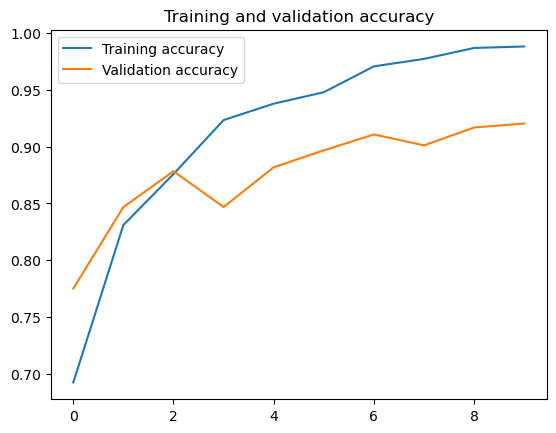

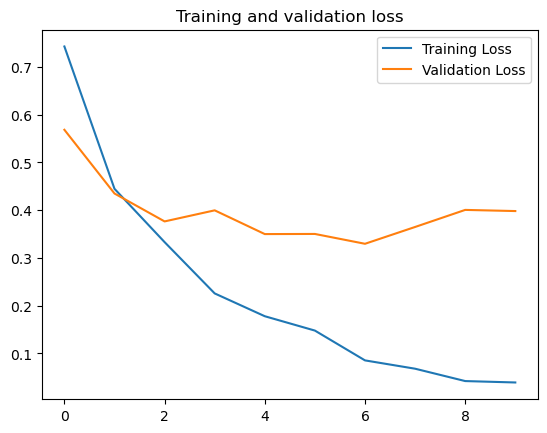

In [24]:
# Plot the loss and accuracy curves for training and validation:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(acc))
plt.plot(epochs,acc,label='Training accuracy')
plt.plot(epochs,val_acc,label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.show()
plt.plot(epochs,loss,label='Training Loss')
plt.plot(epochs,val_loss,label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [25]:
#predict the result:
#Comme les prévisions que vous obtenez sont des valeurs à virgule flottante, 
#il ne sera pas possible de comparer les étiquettes prédites avec les étiquettes de test réelles.
ypred=model.predict(x_valid)

36/36 ━━━━━━━━━━━━━━━━━━━━ 3s 70ms/step 


In [26]:
#ypred[0]

array([8.8304945e-23, 2.3718938e-09, 1.0000000e+00, 1.6348654e-18],
      dtype=float32)

In [27]:
ypred_classes = np.argmax(ypred, axis=1)

In [28]:
#ypred_classes[0]

np.int64(2)

In [29]:
#notre validation labels sont en mode one_hot_encoding donc on doit les transformer avec argmax en :
yy = np.argmax(y_valid, axis=1)

In [30]:
#yy[0]

np.int64(2)

In [31]:
from sklearn.metrics import recall_score, precision_score, f1_score, confusion_matrix

In [32]:
confusion_matrix(ypred_classes, yy)

array([[242,  33,   2,   0],
       [ 19, 209,   4,   3],
       [  3,  13, 312,   0],
       [  0,  13,   1, 289]])

In [33]:
recall_score(ypred_classes, yy, average='micro')

0.9203849518810149

In [34]:
precision_score(ypred_classes, yy, average='micro')

0.9203849518810149

In [35]:
f1_score(ypred_classes, yy, average='micro')

0.9203849518810149

In [36]:
ypred_test = model.predict(X_test)

41/41 ━━━━━━━━━━━━━━━━━━━━ 3s 71ms/step


In [37]:
ypred_test_classes = np.argmax(ypred_test, axis=1)

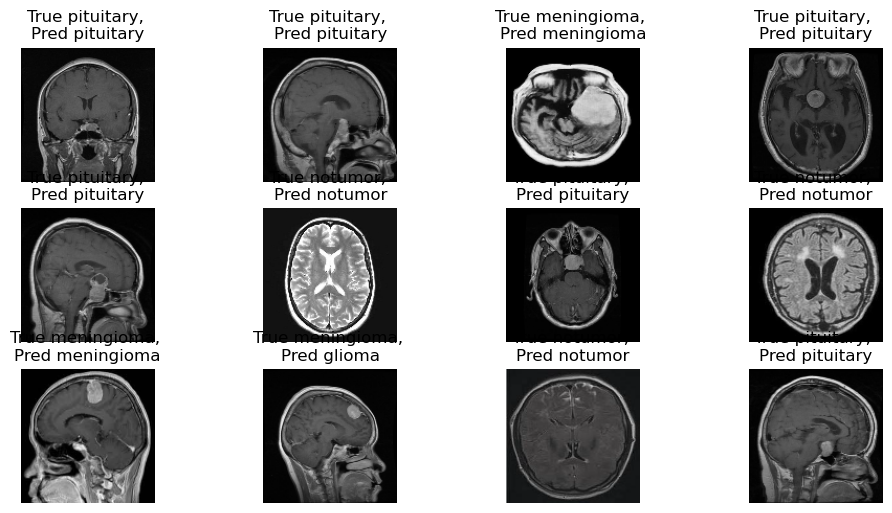

In [52]:
plt.figure(figsize=(12, 8))
for i in range(12):
    idx = np.random.randint(0, len(X_test))
    plt.subplot(4, 4, i+1)
    plt.imshow(X_test[idx])
    #plt.title(f"True:{categories[y_test[idx]]} \n Pred:{categories[ypred_test_classes[idx]]}")
    plt.title("True {}, \nPred {}".format(categories[y_test[idx]], categories[ypred_test_classes[idx]]))
    plt.axis("off")
plt.show()